In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC_Numpyro import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose, result_dict_to_latent_variable_convert_z_to_beta

In [18]:
from PFNExperiments.LatentFactorModels.GenerativeModels.FactorAnalysis.BasicFA import make_fa_program_normal_weight_prior_laplace_z_prior_batched, make_fa_program_normal_weight_prior_laplace_z_prior
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [19]:
N = 50
P = 5
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [29]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(5)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("z_dim", curriculum.constant_scheduler(3)),
    ("w_var", curriculum.constant_scheduler(1.0)),
    ("mu_var", curriculum.constant_scheduler(1.0)),
    ("a1_psi_var", curriculum.constant_scheduler(5.0)),
    ("b1_psi_var", curriculum.constant_scheduler(2.0)),
])
#curriculum.plot_all_schedules()

In [30]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_fa_program_normal_weight_prior_laplace_z_prior_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [31]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [32]:
sample_batch = next(iter(epoch_loader[0][0]))

In [33]:
for key, value in sample_batch.items():
    print(key, value.shape)

x torch.Size([1024, 50, 5])
z torch.Size([1024, 3])
mu torch.Size([1024, 5])
w torch.Size([1024, 12])
psi torch.Size([1024, 5])
beta torch.Size([1024, 3])
time torch.Size([1024])
base_sample_beta torch.Size([1024, 3])


####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


{'X': {'mean': tensor(0.0187), 'variance': tensor(6.2235), 'min': tensor(-18.5814), 'max': tensor(19.4793), 'mean_mean': tensor([-0.0138, -0.0305,  0.0382,  0.0524,  0.0472]), 'variance_mean': tensor([0.5071, 0.4966, 0.4927, 0.5018, 0.4971]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.0166), 'variance': tensor(1.9357), 'min': tensor(-7.8477), 'max': tensor(8.3305), 'mean_mean': tensor(0.0166), 'variance_mean': tensor(1.9414), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([-8.4333e-06,  2.9267e-02,  2.0408e-02])
Variance: tensor([1.8909, 2.0324, 1.8837])
Min: tensor([-6.3793, -7.8477, -7.0723])
Max: tensor([8.3305, 7.8032, 6.5166])
Mean of means: 0.01655558869242668
Mean of variances: 1.9413530826568604
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0163, -0.0269,  0.0257, -0.0246,  0.0108])
Variance: tensor([0.9661, 0.9925, 0.9755, 1.0163, 1.0175])
Min: tensor([-3.4502, -3.7814, -3.8513, -3.5266, -3.7588])
M

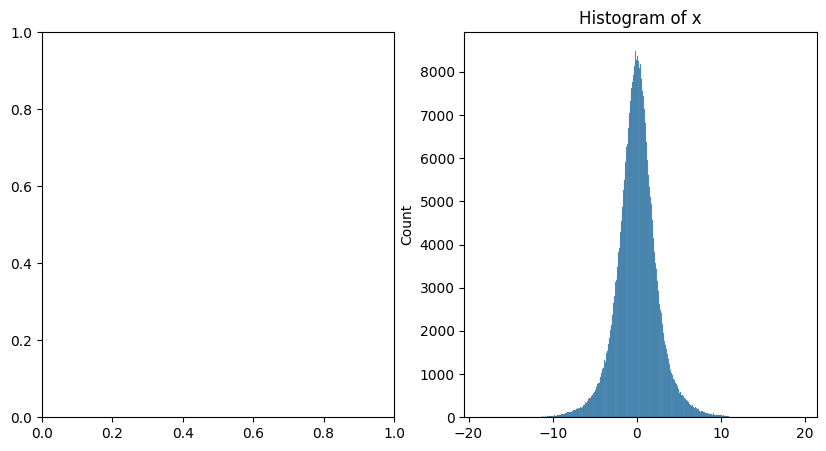

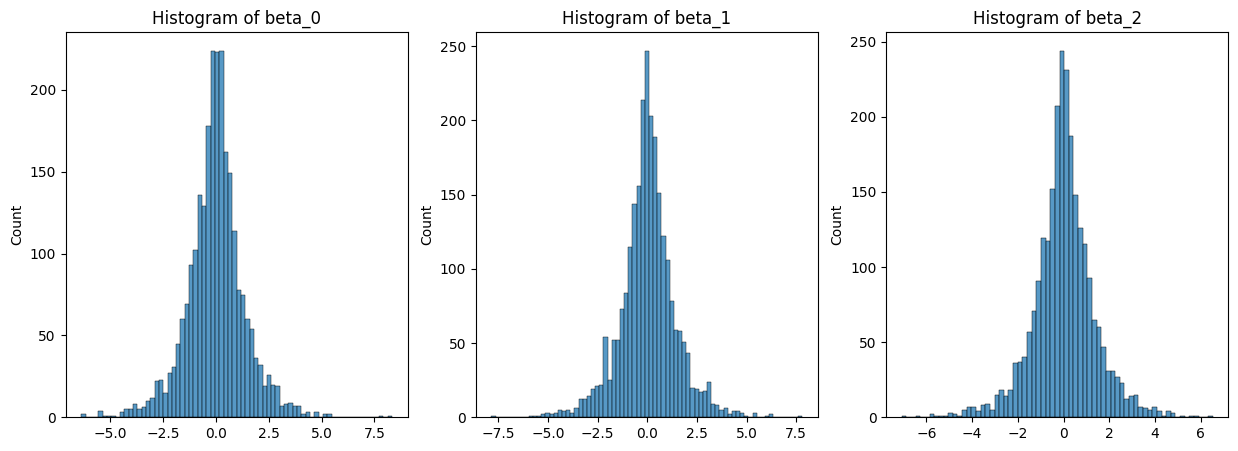

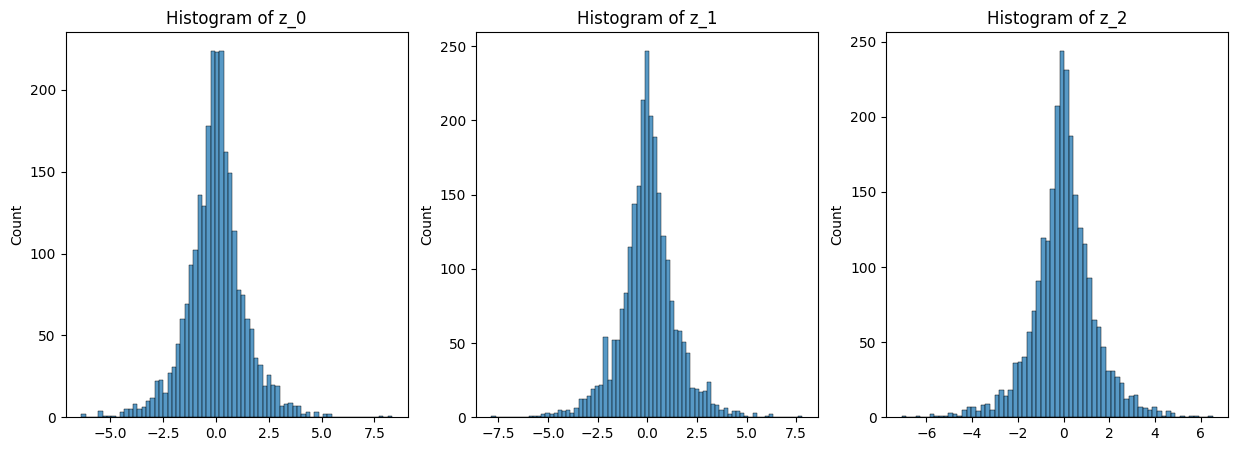

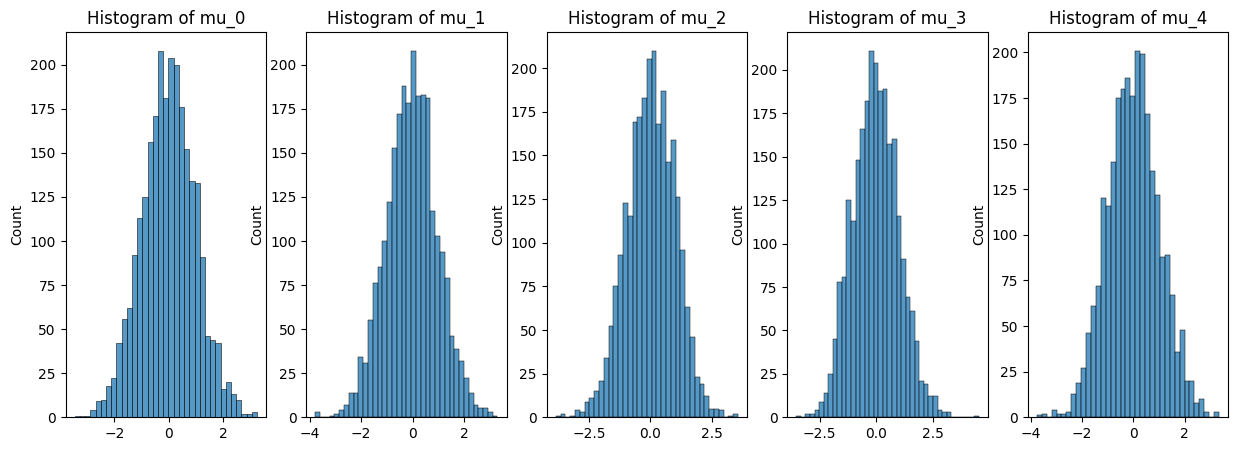

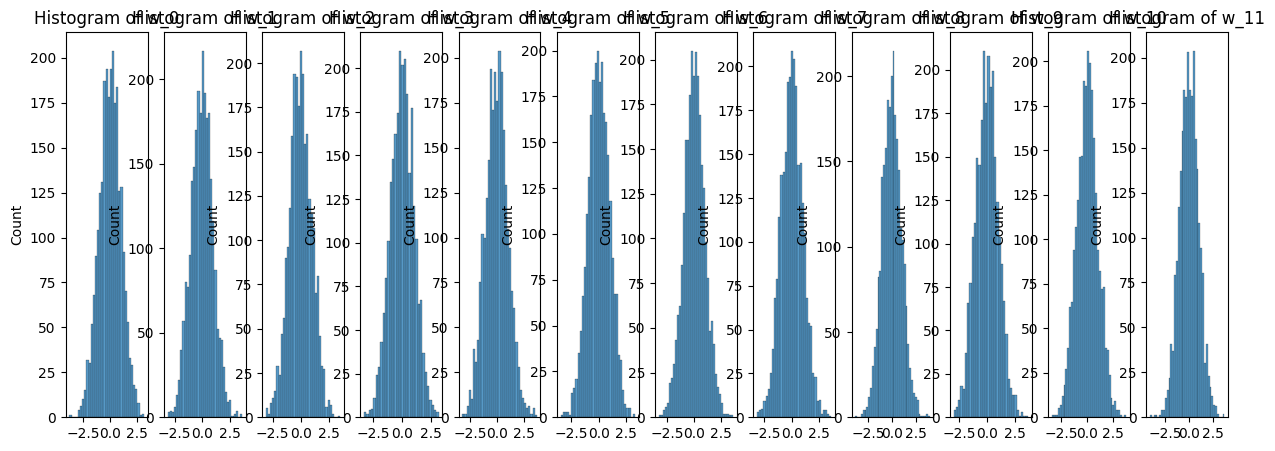

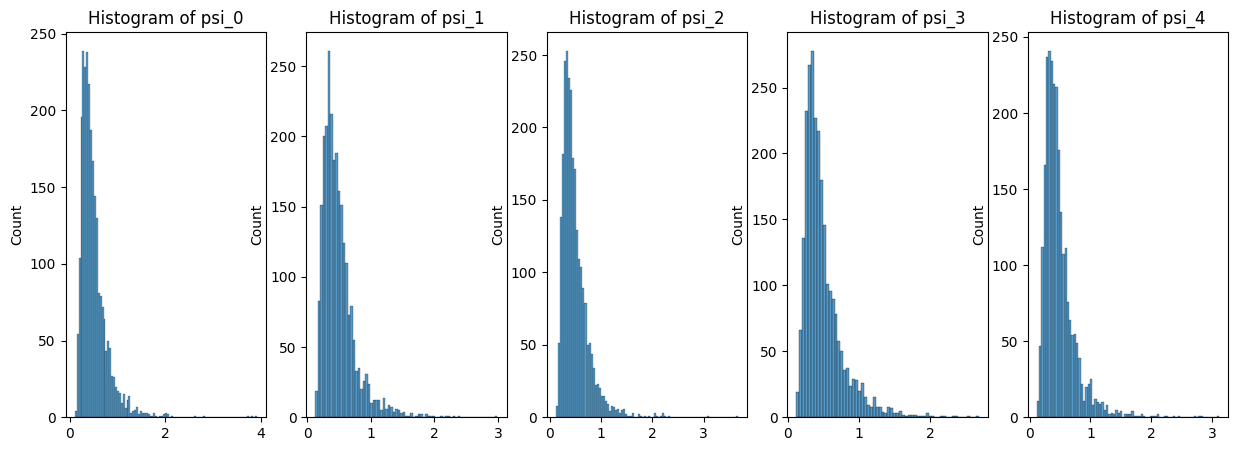

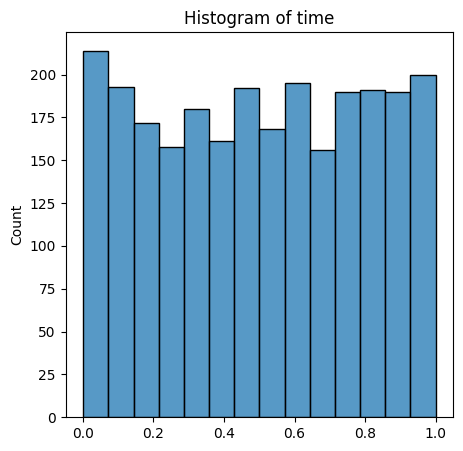

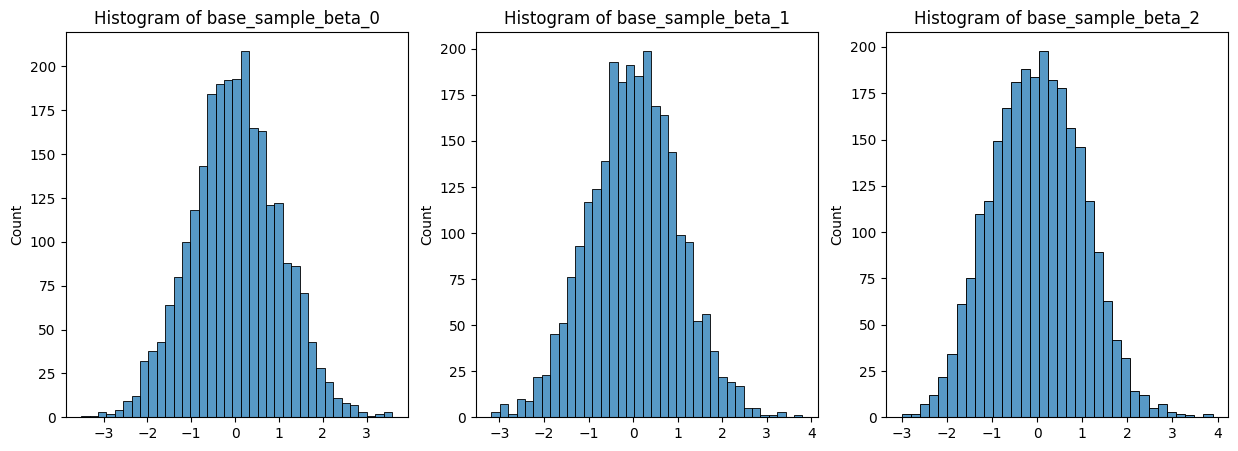

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 19.24it/s]


{'X': {'mean': tensor(-0.0151), 'variance': tensor(6.1403), 'min': tensor(-21.0519), 'max': tensor(19.1763), 'mean_mean': tensor([-0.0100,  0.0452, -0.0108, -0.0807, -0.0193]), 'variance_mean': tensor([0.5121, 0.5043, 0.4975, 0.4948, 0.4970]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.0134), 'variance': tensor(1.9719), 'min': tensor(-9.9711), 'max': tensor(7.7459), 'mean_mean': tensor(0.0134), 'variance_mean': tensor(1.9743), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([ 0.0119,  0.0404, -0.0120])
Variance: tensor([1.8567, 1.9541, 2.1048])
Min: tensor([-7.2690, -9.9711, -8.8632])
Max: tensor([7.7459, 7.4984, 6.4882])
Mean of means: 0.013413704931735992
Mean of variances: 1.974250078201294
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([ 0.0101, -0.0296, -0.0057, -0.0446, -0.0148])
Variance: tensor([1.0111, 1.0208, 0.9940, 1.0176, 1.0261])
Min: tensor([-2.9678, -3.9108, -3.3958, -3.6668, -3.9175])
Max: tensor(

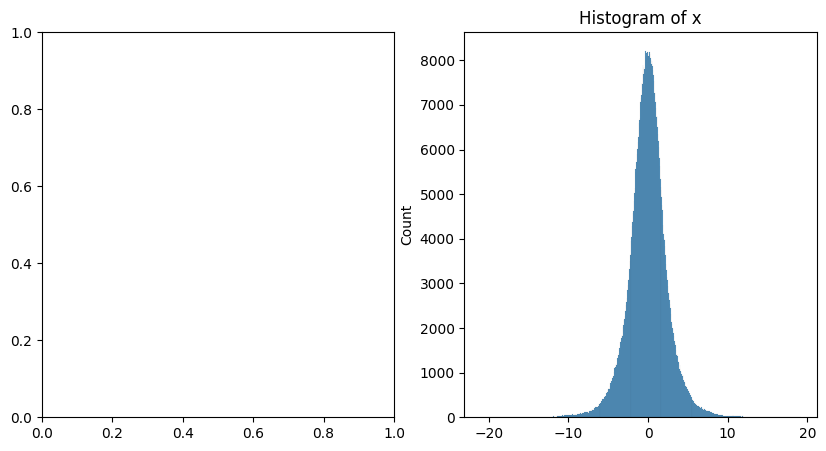

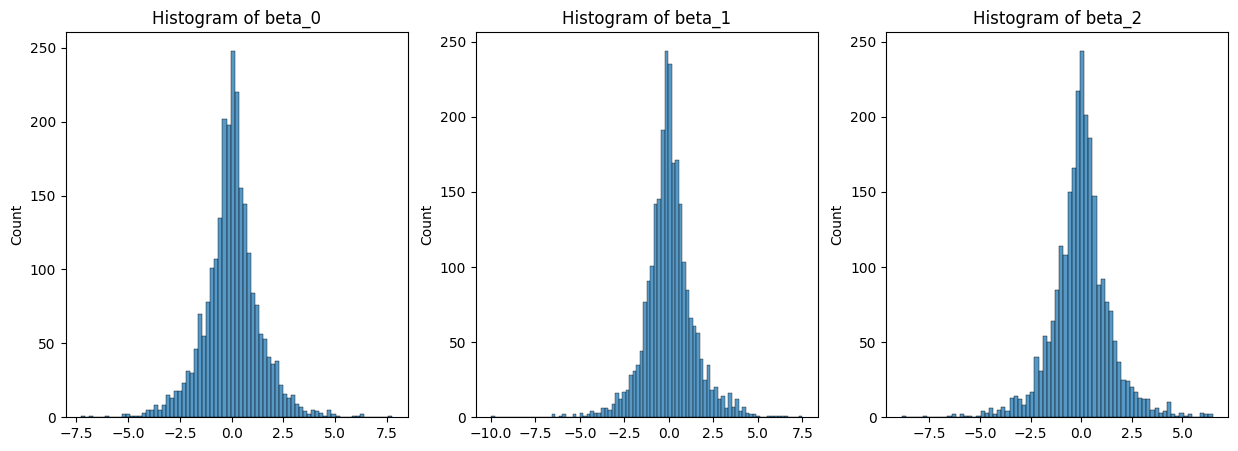

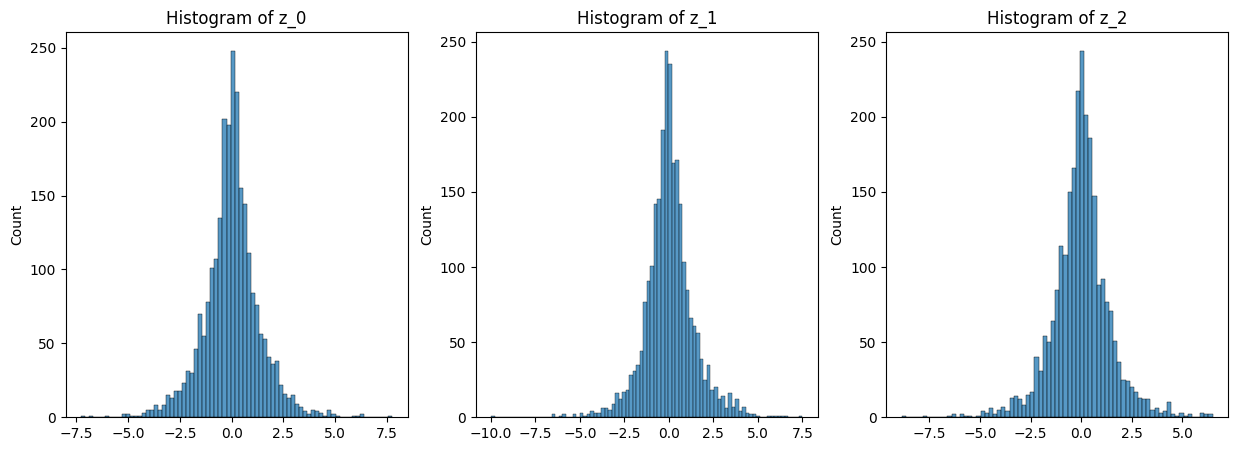

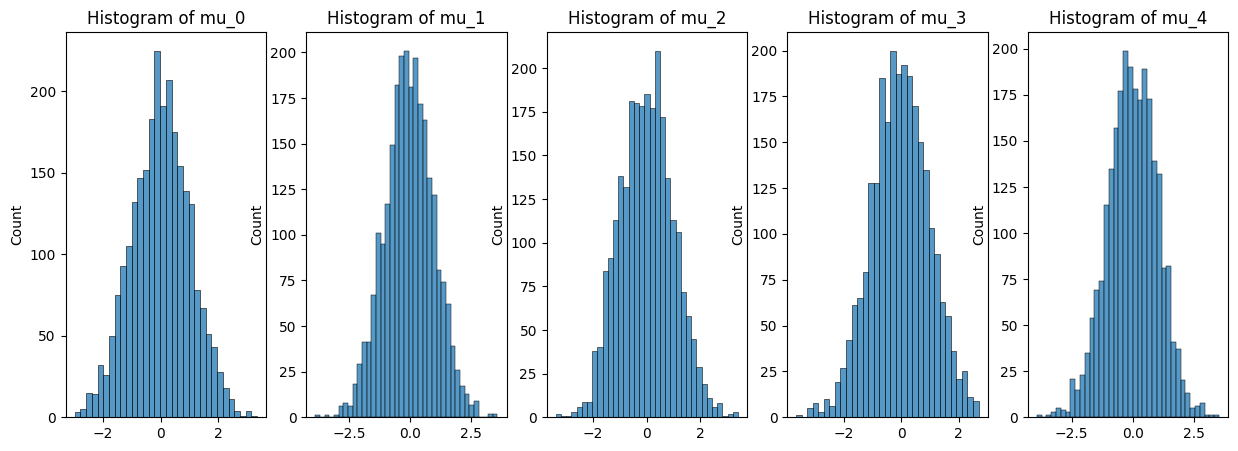

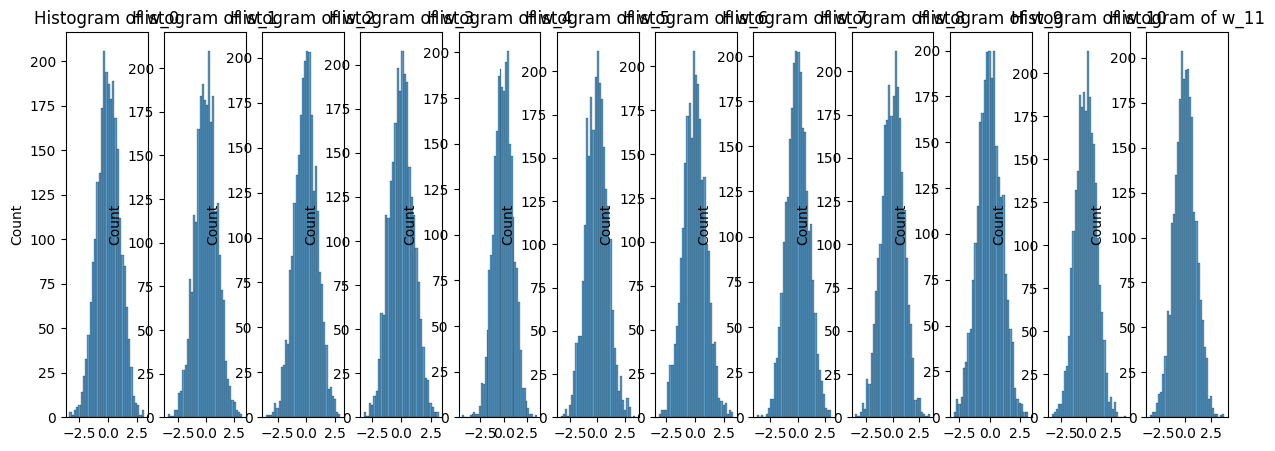

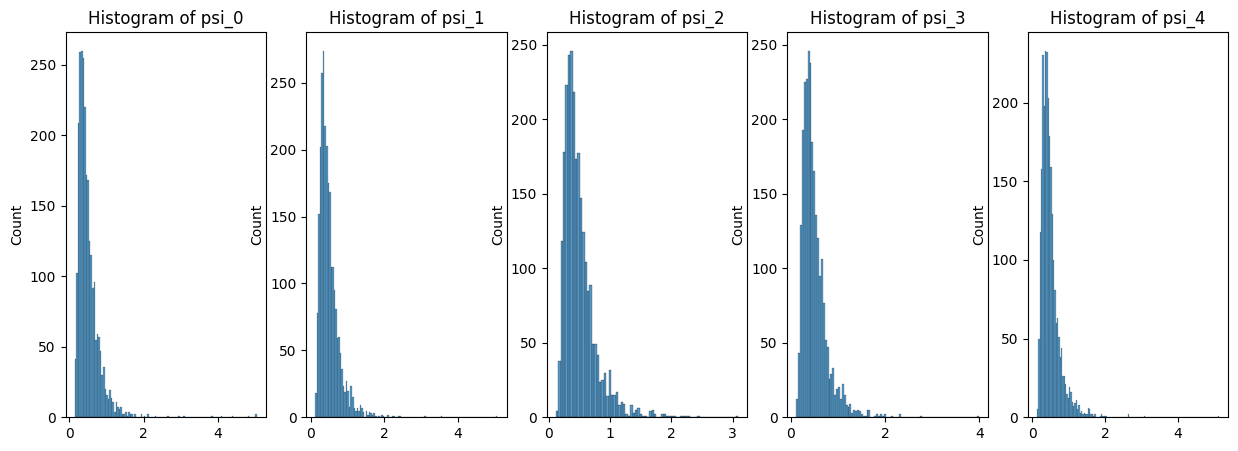

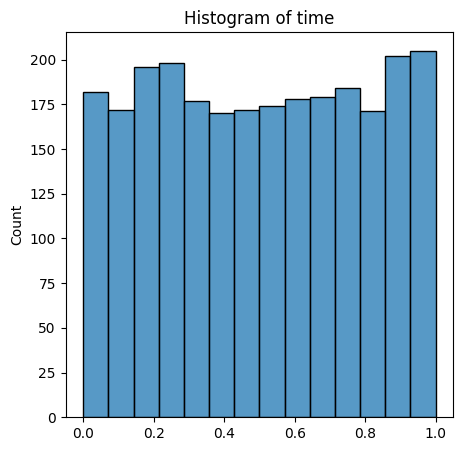

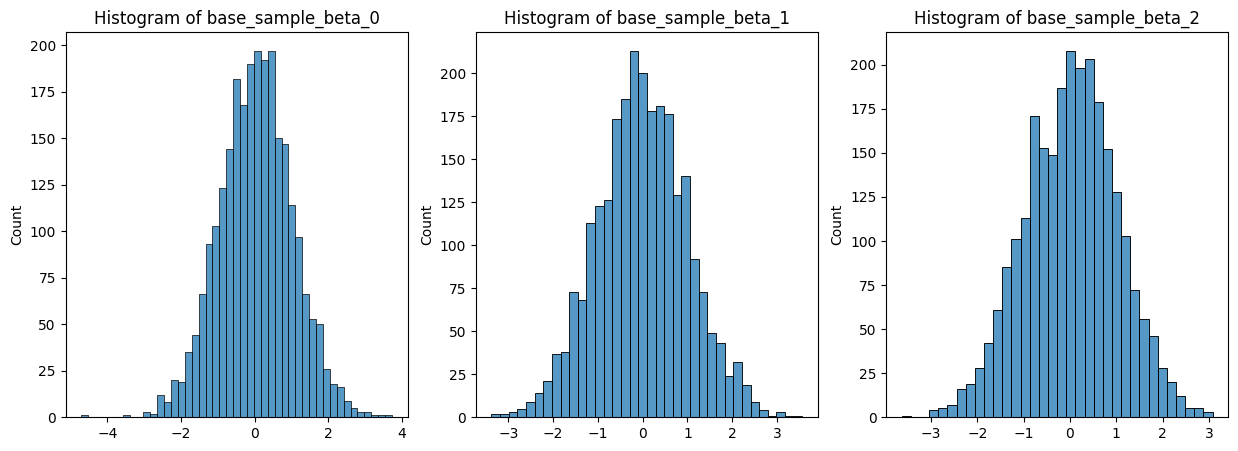

[{'X': {'mean': tensor(0.0187),
   'variance': tensor(6.2235),
   'min': tensor(-18.5814),
   'max': tensor(19.4793),
   'mean_mean': tensor([-0.0138, -0.0305,  0.0382,  0.0524,  0.0472]),
   'variance_mean': tensor([0.5071, 0.4966, 0.4927, 0.5018, 0.4971]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.0166),
   'variance': tensor(1.9357),
   'min': tensor(-7.8477),
   'max': tensor(8.3305),
   'mean_mean': tensor(0.0166),
   'variance_mean': tensor(1.9414),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(-0.0151),
   'variance': tensor(6.1403),
   'min': tensor(-21.0519),
   'max': tensor(19.1763),
   'mean_mean': tensor([-0.0100,  0.0452, -0.0108, -0.0807, -0.0193]),
   'variance_mean': tensor([0.5121, 0.5043, 0.4975, 0.4948, 0.4970]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.0134),
   'variance': tensor(1.9719),
   'min': tensor(-9.9711),
   'max': tensor(7.7459),
   'mean_mean': tensor(0.0134),
   'variance_

In [34]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [35]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [36]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['x', 'z', 'mu', 'w', 'psi', 'beta', 'time', 'base_sample_beta'])

In [37]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 50, 5]), torch.Size([1024, 3]))

In [38]:
2*K

6

In [39]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [40]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [41]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [42]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [43]:
trainer.validate()

100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


{'loss_mean': 3.2045440673828125,
 'loss_median': 3.2308149337768555,
 'loss_std': 0.1188337504863739}

In [44]:
r = trainer.train()

Curriculum parameters: {'n': 50, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 1.0, 'mu_var': 1.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 0


  5%|▍         | 12/244 [00:32<10:27,  2.71s/it] 


KeyboardInterrupt: 

In [46]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_fa_program_normal_weight_prior_laplace_z_prior(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 50, 'p': 5, 'z_dim': 3, 'w_var': 1.0, 'mu_var': 1.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0}


In [47]:
pprogram1()

{'x': tensor([[-1.2665,  0.3545, -4.7308,  1.5518, -1.5785],
         [-1.6369,  0.1788, -5.9649,  1.7151, -1.0028],
         [-1.4660,  0.7418, -6.7031,  1.1470, -3.1582],
         [-0.5665,  0.2664, -4.9215,  1.3880, -2.1791],
         [-1.0808,  0.1411, -4.2377,  1.3757, -4.9016],
         [-0.8140,  0.5735, -4.1265,  2.5590, -2.3748],
         [-1.1605,  0.5582, -5.3162,  1.2851, -2.9944],
         [-0.2494, -0.2306, -4.4886,  1.7124, -3.2220],
         [-0.2113,  0.2186, -5.2408,  1.3486, -2.4960],
         [-0.2029,  0.3394, -5.5601,  1.2091, -2.7901],
         [-0.7832,  0.8958, -3.4768,  2.0149, -1.6301],
         [-0.6628,  1.0029, -4.1346,  1.3047, -3.0901],
         [-0.7249,  1.2581, -3.9023,  1.5432, -2.3358],
         [-1.2431,  0.9599, -4.7313,  0.8863, -2.3075],
         [-0.7317,  0.8175, -4.7984,  2.2146, -2.8072],
         [-1.5698,  0.1840, -5.1259,  2.1031, -2.8578],
         [-0.9490,  1.0011, -4.9702,  1.4341, -2.4602],
         [-0.4318, -0.5641, -4.4181,  1.377

In [48]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [49]:
x_test.shape

torch.Size([1024, 50, 5])

In [50]:
samples = full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


In [51]:
samples["beta"].shape

torch.Size([1000, 3])

In [52]:
str(pprogram1_x)

'<function return_only_x.<locals>.wrapper at 0x000002E15EFC1E10>'

In [54]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Numpyro_Versions.Pyro2Numpyro import pyro_ppgram2_numpyro_ppgram

make_pprogram1_numpyro = pyro_ppgram2_numpyro_ppgram[make_fa_program_normal_weight_prior_laplace_z_prior.__name__]
pprogram1_numpyro = make_pprogram1_numpyro(**benchmark_params_ppgrogram)

In [55]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_numpyro,
    n_samples=500,
    n_warmup=1_000
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000, discrete_z=False)

In [56]:
models

[Hamiltonian Monte Carlo,
 Variational Inference with guide: AutoDiagonalNormal(),
 Variational Inference with guide: AutoMultivariateNormal(),
 Variational Inference with guide: AutoLaplaceApproximation(),
 Variational Inference with guide: AutoIAFNormal(),
 Variational Inference with guide: AutoStructured()]

In [57]:
"""
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)
"""

evaluation = Evaluate(
    posterior_model = hmc,
    evaluation_loader = trainer.testset,
    comparison_models= [models[1]],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_posterior_model = result_dict_to_latent_variable_convert_z_to_beta,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [58]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:20<00:20, 20.85s/it]

....................


100%|██████████| 100/100 [00:00<00:00, 489.39it/s]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 536.34it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,Hamiltonian Monte Carlo Numpyro,gt,62.506403,3.572235,NaN,-3.502646,0.460566,0.532920,0.035420,0.002257,NaN,0.560197,0.020236,0.117310
1,Variational Inference with guide: AutoDiagonal...,gt,62.473240,3.570580,NaN,-5403.030624,0.949943,0.950899,0.003803,0.000167,NaN,6342.231919,0.660716,0.647745


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,Hamiltonian Monte Carlo Numpyro,Variational Inference with guide: AutoDiagonal...,0.5,0.5,NaN,0.5,0.5,0.5



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,Hamiltonian Monte Carlo Numpyro,Variational Inference with guide: AutoDiagonal...,1.866141,2.769298,0.9975,0.639173,0.668274,0.003536


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0                    Hamiltonian Monte Carlo Numpyro  gt   
  1  Variational Inference with guide: AutoDiagonal...  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                          62.506403            3.572235   
  1                                          62.473240            3.570580   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                     NaN                     -3.502646   
  1                     NaN                  -5403.030624   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                    0.460566                     0.532920   
  1                    0.949943                     0.950899   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.035420          0.002257   

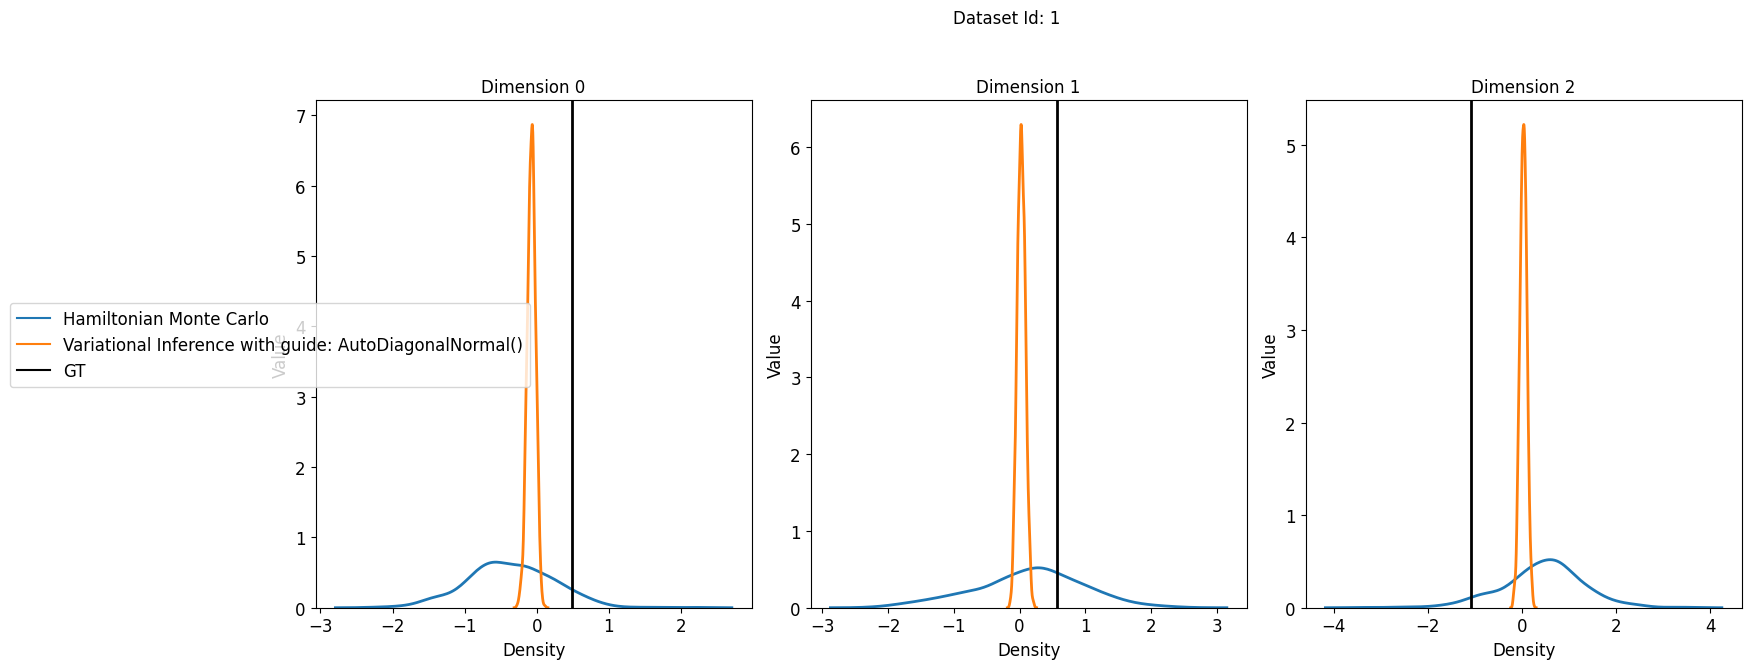

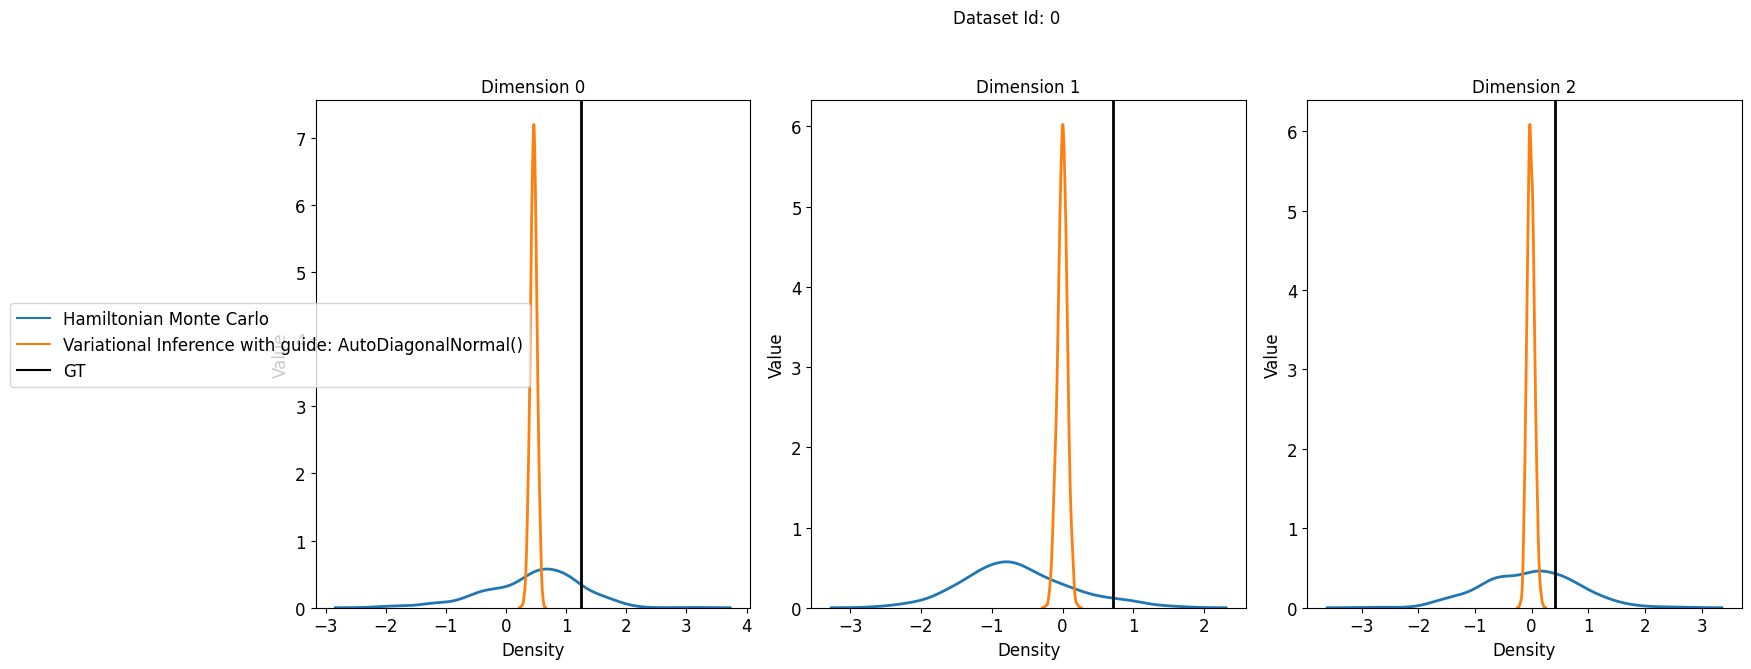

In [77]:
evaluation.plot_results()

In [73]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [74]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [75]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = [models[1]],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [76]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

......

Sampling posterior:   0%|          | 0/2 [00:06<?, ?it/s]


KeyboardInterrupt: 